In [1]:
# Attribution methods

"""
Attribution methods are techniques used to understand the contribution of each input feature to the model's output.
"""
"""
The Integrated Gradients(IG) is an attribution technique that helps in
improving our understanding of the network, performing
debugging, performing rule extraction, or aiding an end
user in understanding the network’s prediction
"""

'\nThe Integrated Gradients(IG) is an attribution technique that helps in\nimproving our understanding of the network, performing\ndebugging, performing rule extraction, or aiding an end\nuser in understanding the network’s prediction\n'

In [2]:
# Axioms that should be satisfied to be called attribution methods

# 1. Sensitivity
"""
The definition states that for every pair of input and baseline (a reference input)
that differ in one feature but have different predictions, the differing feature
should be given a non-zero attribution.

In simpler terms, if changing a particular feature from the baseline to the input
leads to a change in prediction, the attribution method should assign a non-zero
importance to that feature.
"""

# for example, Gradients as attribution method does not satisfy this property.
"""
The example provided involves a simple one-variable, one-ReLU network: f(x)=1−ReLU(1−x).
The baseline is set at x=0, and the input is x=2.

The function changes from 0 to 1 as xx changes. However, because the function
becomes flat (has zero gradient) at x=1x=1, the gradient-based attribution method
assigns an attribution of 0 to xx.

"""
# Note: In this Gradient method, The attribution is zero for features with zero gradient
# at the input despite a non-zero gradient at the baseline.

'\nThe example provided involves a simple one-variable, one-ReLU network: f(x)=1−ReLU(1−x).\nThe baseline is set at x=0, and the input is x=2.\n\nThe function changes from 0 to 1 as xx changes. However, because the function\nbecomes flat (has zero gradient) at x=1x=1, the gradient-based attribution method\nassigns an attribution of 0 to xx.\n\n'

In [3]:
# 2. Implementation Invariance

"""
Two networks are functionally equivalent if their outputs
are equal for all inputs, despite having very different implementations.
Attribution methods should satisfy Implementation
Invariance, i.e., the attributions are always identical
for two functionally equivalent networks.

First, notice that gradients are invariant to implementation.
In fact, the chain-rule for gradients
   df/dg = df/dh x dh/dg
 is essentially about implementation invariance.

Therefore, backpropagation technique satisfy Implementation Invariance
"""

'\nTwo networks are functionally equivalent if their outputs\nare equal for all inputs, despite having very different implementations.\nAttribution methods should satisfy Implementation\nInvariance, i.e., the attributions are always identical\nfor two functionally equivalent networks.\n\nFirst, notice that gradients are invariant to implementation.\nIn fact, the chain-rule for gradients\n   df/dg = df/dh x dh/dg\n is essentially about implementation invariance.\n\nTherefore, backpropagation technique satisfy Implementation Invariance\n'

In [4]:
# Integrated Gradients
"""
Specifically, integrated gradients
are defined as the path intergral of the gradients along the
straightline path from the baseline x0 to the input x.
"""

'\nSpecifically, integrated gradients\nare defined as the path intergral of the gradients along the\nstraightline path from the baseline x0 to the input x.\n'

In [1]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

In [2]:
# get the model layers (which is already trained) from the page where it is published
# https://www.kaggle.com/models/google/inception-v1/frameworks/tensorFlow2/variations/classification/versions/1?tfhub-redirect=true


model = tf.keras.Sequential([
    hub.KerasLayer(
        name='inception_v1',
        handle='https://tfhub.dev/google/imagenet/inception_v1/classification/4',
        trainable=False),
])
model.build([None, 224, 224, 3])  # Input shape = [batch_size, 224, 224, 3]
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v1 (KerasLayer)   (None, 1001)              6633209   
                                                                 
Total params: 6633209 (25.30 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 6633209 (25.30 MB)
_________________________________________________________________


In [7]:
"""
The output is a batch of logits vectors. The indices into the logits are the
num_classes = 1001 classes of the classification from the original training.

The mapping from indices to class labels can be found in the file at
download.tensorflow.org/data/ImageNetLabels.txt (with class 0 for "background",
followed by 1000 actual ImageNet classes).

The input images are expected to have color values in the range [0,1], following
 the common image input conventions. The expected size of the input images is height
 x width = 224 x 224 pixels by default, but other input sizes are possible
 (within limits).
 """

'\nThe output is a batch of logits vectors. The indices into the logits are the\nnum_classes = 1001 classes of the classification from the original training.\n\nThe mapping from indices to class labels can be found in the file at\ndownload.tensorflow.org/data/ImageNetLabels.txt (with class 0 for "background",\nfollowed by 1000 actual ImageNet classes).\n\nThe input images are expected to have color values in the range [0,1], following\n the common image input conventions. The expected size of the input images is height\n x width = 224 x 224 pixels by default, but other input sizes are possible\n (within limits).\n '

In [8]:
# Outputs: A tf.Tensor of logits in the shape of (batch_size, 1001).
# Each row represents the model's predicted score for 1,001 classes from ImageNet.


In [3]:
def load_imagenet_output_labels(file_path):
  """
  Args:
    file_path(str): A URL download path.
  Returns:
    imagenet_label_array(numpy.ndarray): Array of strings with shape (1001,).
  """

  labels_file = tf.keras.utils.get_file('ImageNetLabels.txt', file_path)

  with open(labels_file, "r") as reader:
    f = reader.read()
    labels = f.splitlines()
    imagenet_label_array = np.array(labels)

  return imagenet_label_array

In [4]:
imagenet_labels = load_imagenet_output_labels(
    'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

10484/10484 [==============================] - 0s 0us/step


In [52]:
with open("output_labels.txt", "w") as txt_file:
    for line in imagenet_labels:
        txt_file.write("".join(line) + "\n")

In [20]:
imagenet_labels[418], imagenet_labels[523]

('balloon', 'croquet ball')

In [6]:
imagenet_labels[0], imagenet_labels[10], imagenet_labels[100]

('background', 'ostrich', 'goose')

In [9]:
# Get Image Urls as a dictionary of image title and its image url link
img_url = {
    'Fireboat': 'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg',
    'Giant Panda': 'http://storage.googleapis.com/download.tensorflow.org/example_images/Giant_Panda_2.jpeg',
}

In [10]:
# Create dictionary of image paths after downloading images from above urls
image_paths = {name: tf.keras.utils.get_file(name, url_path) for (name, url_path) in img_url.items()}

802859/802859 [==============================] - 0s 0us/step


In [7]:
custom_img_paths = {'Ballon': '/content/balloon.jpeg'}

In [11]:
image_paths, custom_img_paths

({'Fireboat': '/root/.keras/datasets/Fireboat',
  'Giant Panda': '/root/.keras/datasets/Giant Panda'},
 {'Ballon': '/content/balloon.jpeg'})

In [12]:
def read_image(file_name):
  image = tf.io.read_file(file_name)
  image = tf.io.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
  return image

In [13]:
# Read image and extract image tensors
img_name_tensors = {name: read_image(img_path) for (name, img_path) in custom_img_paths.items()}

In [14]:
def showImagePlots(img_name_tensors):
  plt.figure(figsize=(8, 8))
  for n, (name, img_tensors) in enumerate(img_name_tensors.items()):
    ax = plt.subplot(1, 2, n+1)
    ax.imshow(img_tensors)
    ax.set_title(name)
    ax.axis('off')
  plt.tight_layout()

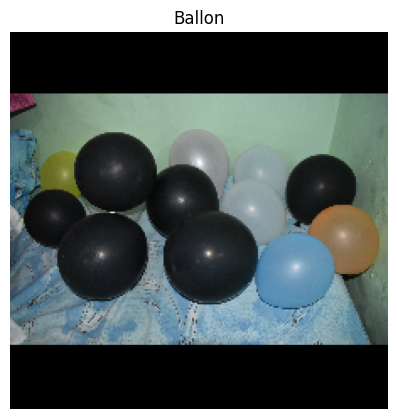

In [15]:
showImagePlots(img_name_tensors)

In [16]:
# Get top K predictions along with its probabilities
def top_k_predictions(img, k=3):
  image_batch = tf.expand_dims(img, 0)
  predictions = model(image_batch)   # returns logits
  probs = tf.nn.softmax(predictions, axis=-1)   # convert logits into probabilities for all class labels
  top_probs, top_idxs = tf.math.top_k(input=probs, k=k)
  top_labels = imagenet_labels[tuple(top_idxs)]
  return top_labels, top_probs[0]

In [17]:
#

for name, img_tensors in img_name_tensors.items():
  print(name)
  print('\n')

  k = 3
  labels, pred_probs = top_k_predictions(img_tensors, k)
  for i in range(k):
    print(f'{labels[i]}: {pred_probs[i]:0.1%} \n')

  print("*************************** \n")


Ballon


croquet ball: 50.6% 

balloon: 7.1% 

pool table: 6.0% 

*************************** 



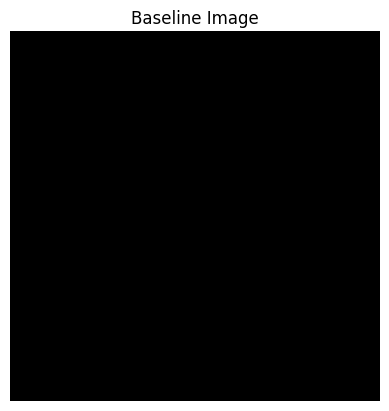

In [21]:
# Crate Baseline image for Integrated Gradients calculations

baseline = tf.zeros(shape=(224,224,3))

plt.imshow(baseline)
plt.title("Baseline Image")
plt.axis('off')
plt.show()

In [22]:
# Interpolate Images with different intervals w.r.t baseline Image

m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below.
alphas

<tf.Tensor: shape=(51,), dtype=float32, numpy=
array([0.        , 0.02      , 0.04      , 0.06      , 0.08      ,
       0.09999999, 0.12      , 0.14      , 0.16      , 0.17999999,
       0.19999999, 0.22      , 0.24      , 0.26      , 0.28      ,
       0.29999998, 0.32      , 0.34      , 0.35999998, 0.38      ,
       0.39999998, 0.42      , 0.44      , 0.45999998, 0.48      ,
       0.5       , 0.52      , 0.53999996, 0.56      , 0.58      ,
       0.59999996, 0.62      , 0.64      , 0.65999997, 0.68      ,
       0.7       , 0.71999997, 0.74      , 0.76      , 0.78      ,
       0.79999995, 0.82      , 0.84      , 0.85999995, 0.88      ,
       0.9       , 0.91999996, 0.94      , 0.96      , 0.97999996,
       1.        ], dtype=float32)>

In [23]:
# To generate interpolated images along a linear path
def Interpolate_Images(image, baseline_image, alphas):
  """
  interpolated = baseline + alpha*(real - baseline)
  """
  alphas = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]  # Need 4 dimension similar to images
  baseline = tf.expand_dims(baseline_image, axis=0)# Need 4 dimension similar to images
  image = tf.expand_dims(image, axis=0)# Need 4 dimension similar to images
  diff = image - baseline
  interpolated = baseline + alphas*diff
  return interpolated

In [25]:
image = img_name_tensors['Ballon']
interpolated_images = Interpolate_Images(image,baseline,alphas)

In [26]:
interpolated_images.shape  # generated 51 interpolated images

TensorShape([51, 224, 224, 3])

In [27]:
def show_interpolated_images(interpolated_images, alphas):
  fig = plt.figure(figsize=(20, 20))

  i = 0
  # take only images at the interval of 10
  for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
    i += 1
    plt.subplot(1, len(alphas[0::10]), i)
    plt.title(f'alpha: {alpha:.1f}')
    plt.imshow(image)
    plt.axis('off')

  plt.tight_layout();

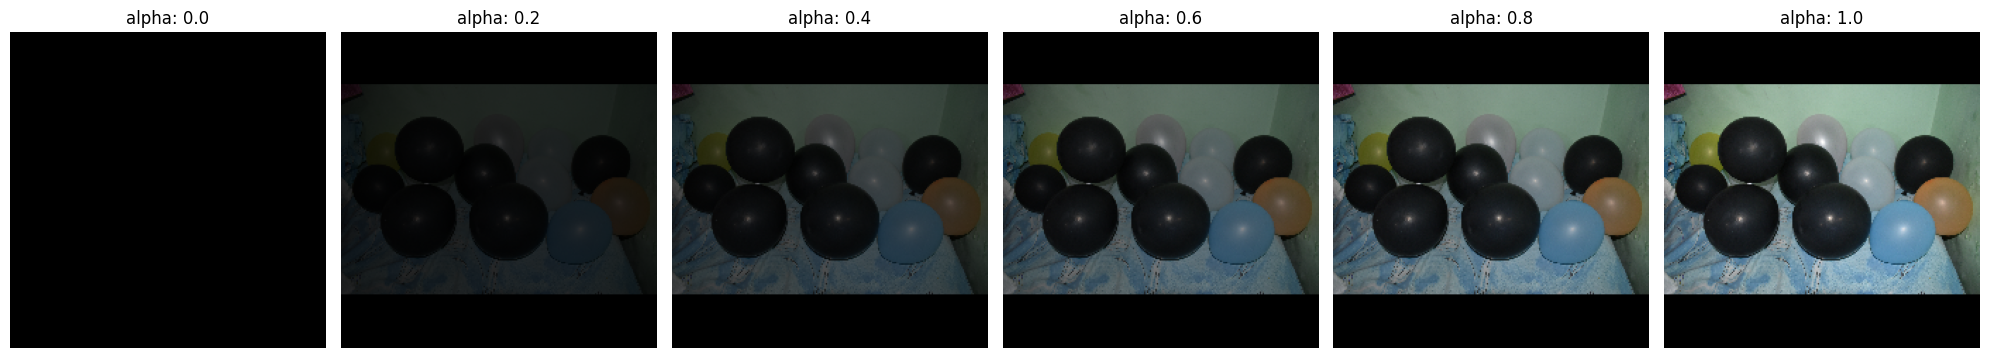

In [28]:
show_interpolated_images(interpolated_images, alphas)

In [29]:
# Computing Gradients and Integrating it over intervals using Reimann sum

def compute_gradients(images, target_labels_idx):

  with tf.GradientTape() as tape:
    tape.watch(images)
    logits = model(images)
    # calculate prediction probabilities of the target_class mentioned in all interpolated images
    pred_probs = tf.nn.softmax(logits, axis=-1)[:, target_labels_idx]

  return tape.gradient(pred_probs, images)



In [30]:
print(f'target_class with Id = 523, is : {imagenet_labels[523]}')
path_gradients = compute_gradients( interpolated_images, 523)

target_class with Id = 523, is : croquet ball


In [31]:
path_gradients.shape # should be same as interpolated_images dimensions

TensorShape([51, 224, 224, 3])

In [32]:
path_gradients[0].shape

TensorShape([224, 224, 3])

In [35]:
pred = model(interpolated_images)
pred_proba = tf.nn.softmax(pred, axis=-1)[:, 523]

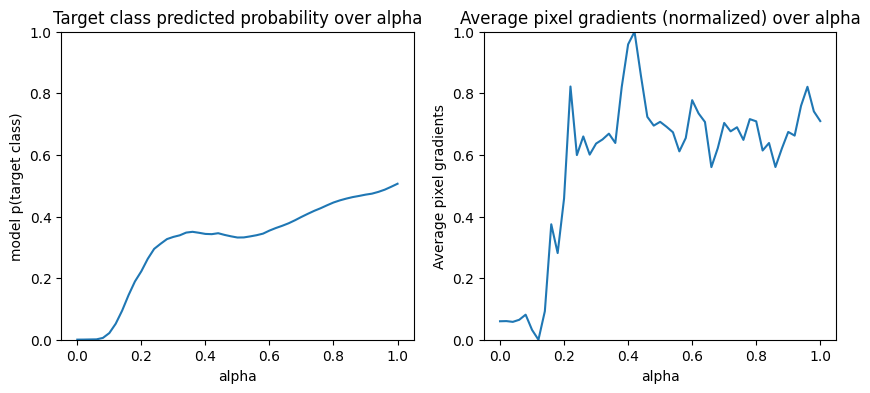

In [36]:
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1]);

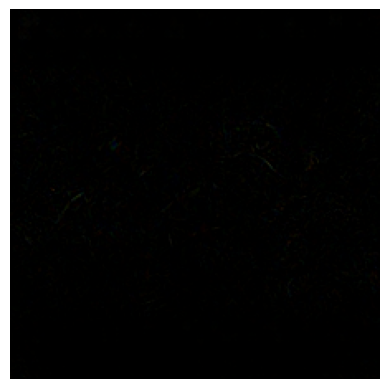

In [38]:
plt.imshow(path_gradients[23])
plt.axis('off')
plt.show()

In [39]:
ss = path_gradients[1:]
ss.shape

TensorShape([50, 224, 224, 3])

In [40]:
# The integral_approximation function takes the gradients of the predicted probability of
# the target class with respect to the interpolated images between the baseline and the original image.

def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)  # average all the interpolated images
  return integrated_gradients

In [41]:
integrated_gradients = integral_approximation(path_gradients)

In [42]:
integrated_gradients.shape

TensorShape([224, 224, 3])

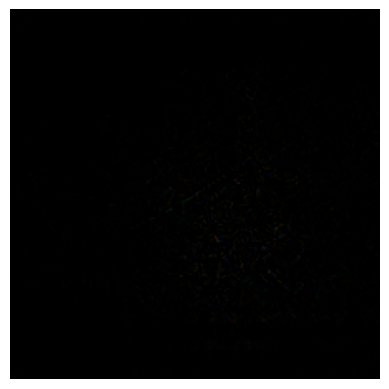

In [39]:
plt.imshow(integrated_gradients)
plt.axis('off')
plt.show()

In [40]:
image = img_name_tensors['Fireboat']
#image
ig = (image - baseline) * integrated_gradients

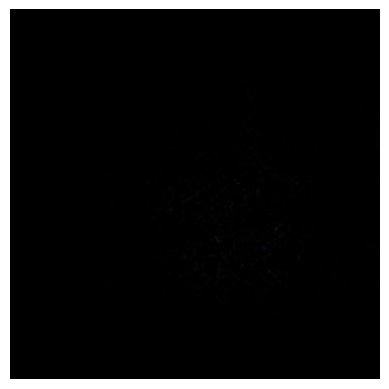

In [41]:
plt.imshow(ig)
plt.axis('off')
plt.show()

In [43]:
# Combining All together in a more scaled fashion

In [44]:
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
  # Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Collect gradients.
  gradient_batches = []

  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx)
    gradient_batches.append(gradient_batch)

  # Concatenate path gradients together row-wise into single tensor.
  total_gradients = tf.concat(gradient_batches, axis=0)

  # Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients

In [45]:
@tf.function
def one_batch(baseline, image, alpha_batch, target_class_idx):
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = Interpolate_Images(image, baseline, alpha_batch)

    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(interpolated_path_input_batch, target_class_idx)
    return gradient_batch

In [46]:
ig_attributions = integrated_gradients(baseline,
                                       img_name_tensors['Ballon'],
                                       target_class_idx=523,
                                       m_steps=240)

In [47]:
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

  attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

  axs[0, 0].set_title('Baseline image')
  axs[0, 0].imshow(baseline)
  axs[0, 0].axis('off')

  axs[0, 1].set_title('Original image')
  axs[0, 1].imshow(image)
  axs[0, 1].axis('off')

  axs[1, 0].set_title('Attribution mask')
  axs[1, 0].imshow(attribution_mask, cmap=cmap)
  axs[1, 0].axis('off')

  axs[1, 1].set_title('Overlay')
  axs[1, 1].imshow(attribution_mask, cmap=cmap)
  axs[1, 1].imshow(image, alpha=overlay_alpha)
  axs[1, 1].axis('off')

  plt.tight_layout()
  return fig

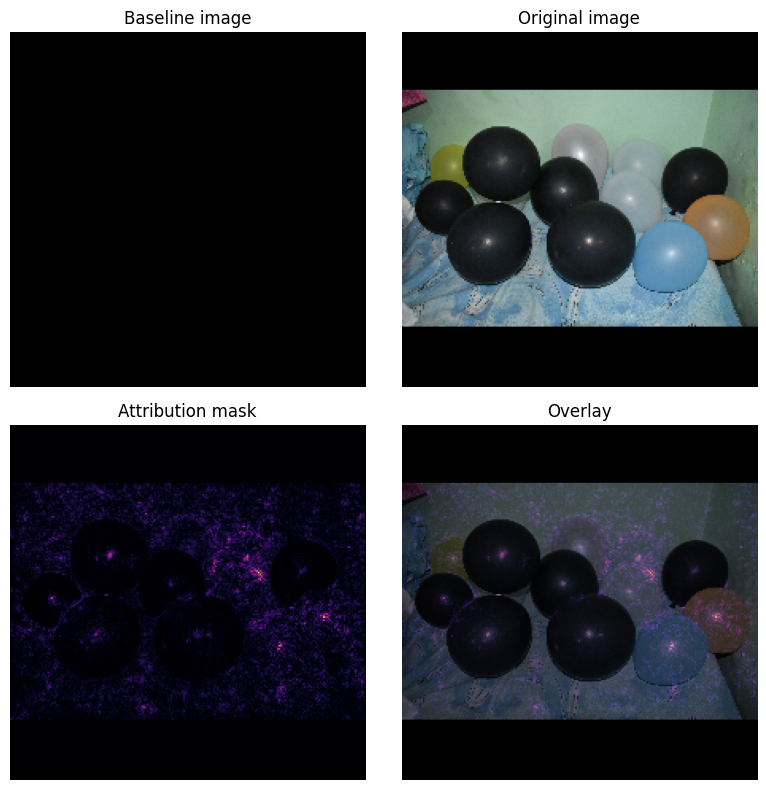

In [48]:
_ = plot_img_attributions(image=img_name_tensors['Ballon'],
                          baseline=baseline,
                          target_class_idx=523,
                          m_steps=240,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

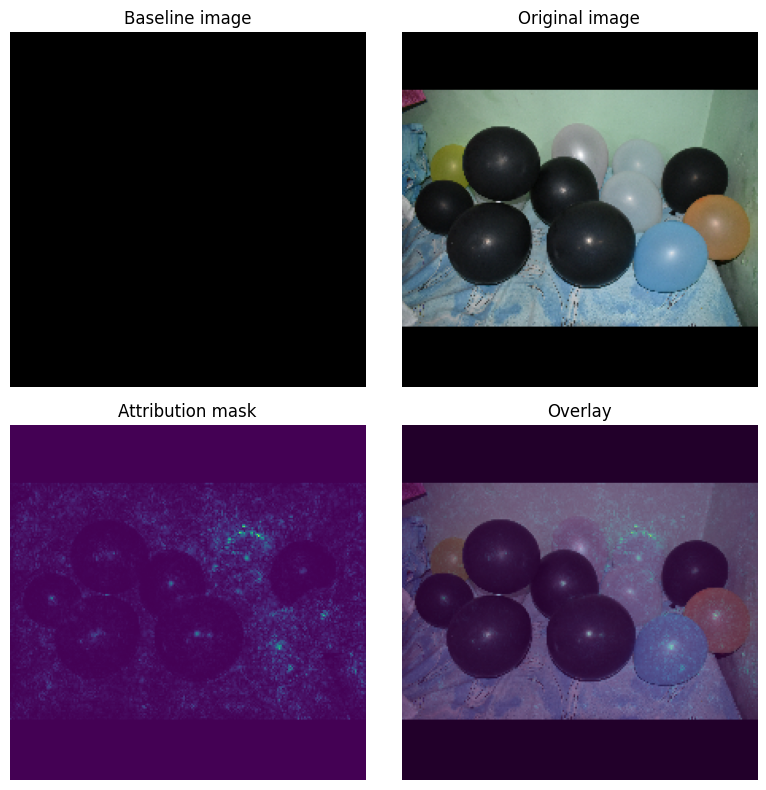

In [50]:
_ = plot_img_attributions(image=img_name_tensors['Ballon'],
                          baseline=baseline,
                          target_class_idx=418,
                          m_steps=150,
                          cmap=plt.cm.viridis,
                          overlay_alpha=0.5)